In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
og_df = pd.read_csv('../out_LED.csv')
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

t_stim_and_led_tuple = [(row['intended_fix'], row['LED_onset_time']) for _, row in df.iterrows()]

ABL_arr = df['ABL'].unique()
ABL_arr.sort()

ILD_arr = df['ILD'].unique()
ILD_arr.sort()

# percentage of LED on trials
frac_of_led = df['LED_trial'].values.sum() / df['LED_trial'].values.size
print(f'frac_of_led: {frac_of_led}')

frac_of_led: 0.33939811074203746


In [3]:
df_repeated_aborts_removed = df.copy()
repeated_abort_row_idx = []
# trial ids 
trial_ids = df_repeated_aborts_removed.index

for i in range(len(trial_ids)-1):
    current_trial = trial_ids[i]
    next_trial = trial_ids[i+1]

    if df_repeated_aborts_removed.loc[current_trial, 'abort_event'] == 3 \
        and df_repeated_aborts_removed.loc[current_trial, 'timed_fix'] > df_repeated_aborts_removed.loc[current_trial, 'LED_onset_time'] \
        and next_trial - current_trial == 1:

        ABL_match = df_repeated_aborts_removed.loc[current_trial, 'ABL'] == df_repeated_aborts_removed.loc[next_trial, 'ABL']
        ILD_match = df_repeated_aborts_removed.loc[current_trial, 'ILD'] == df_repeated_aborts_removed.loc[next_trial, 'ILD']
        LED_trial_match = df_repeated_aborts_removed.loc[current_trial, 'LED_trial'] == df_repeated_aborts_removed.loc[next_trial, 'LED_trial']


        if ABL_match and ILD_match and LED_trial_match:
            repeated_abort_row_idx.append(current_trial+1)


In [4]:
# convert repeated_abort_row_idx to set
repeated_abort_row_idx = set(repeated_abort_row_idx)

In [5]:
# Remove rows at once from the DataFrame
df_repeated_aborts_removed.drop(index=repeated_abort_row_idx, inplace=True)


In [6]:
# len(df_repeated_aborts_removed), len(df)
print(f'og len of df = {len(df)}, new len of df = {len(df_repeated_aborts_removed)}')

og len of df = 100251, new len of df = 87259


In [7]:
# frac of LED_trial = 1 and 0 in new df
frac_of_led = df_repeated_aborts_removed['LED_trial'].values.sum() / df_repeated_aborts_removed['LED_trial'].values.size
print(f'frac_of_led: {frac_of_led}')

frac_of_led: 0.3290319623190731


# see truncated aborts rate norm to num of LED on and off trials

In [8]:
T_trunc = 0.3

In [9]:
aborts_truncated_ON_df = df_repeated_aborts_removed[ (df_repeated_aborts_removed['LED_trial'] == 1) \
                                                 & (df_repeated_aborts_removed['timed_fix'] < df_repeated_aborts_removed['intended_fix']) \
                                                  & (df_repeated_aborts_removed['timed_fix'] > T_trunc)]
aborts_truncated_OFF_df = df_repeated_aborts_removed[ (df_repeated_aborts_removed['LED_trial'] == 0) \
                                                    & (df_repeated_aborts_removed['timed_fix'] < df_repeated_aborts_removed['intended_fix']) \
                                                    & (df_repeated_aborts_removed['timed_fix'] > T_trunc)]

In [10]:
aborts_ON_wrt_LED = aborts_truncated_ON_df['timed_fix'] - aborts_truncated_ON_df['LED_onset_time']
aborts_OFF_wrt_LED = aborts_truncated_OFF_df['timed_fix'] - aborts_truncated_OFF_df['LED_onset_time']

frac_of_aborts_ON = len(aborts_truncated_ON_df) / len(df_repeated_aborts_removed[df_repeated_aborts_removed['LED_trial'] == 1])
frac_of_aborts_OFF = len(aborts_truncated_OFF_df) / len(df_repeated_aborts_removed[df_repeated_aborts_removed['LED_trial'] == 0])

In [11]:
bin_width = 0.05
bins = np.arange(-1, 2, 0.05)
aborts_ON_wrt_LED_hist, _ = np.histogram(aborts_ON_wrt_LED, bins=bins, density=True)
aborts_OFF_wrt_LED_hist, _ = np.histogram(aborts_OFF_wrt_LED, bins=bins, density=True)

aborts_ON_wrt_LED_hist *= frac_of_aborts_ON
aborts_OFF_wrt_LED_hist *= frac_of_aborts_OFF

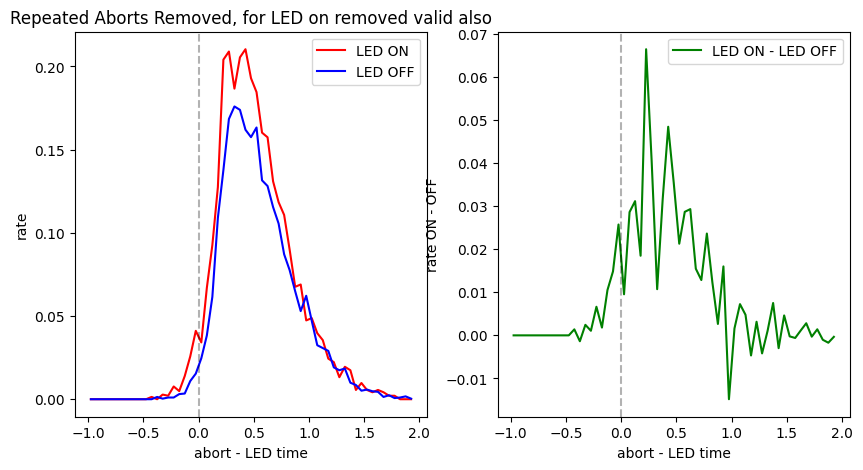

In [12]:
t_pts = bins[:-1] + bin_width/2

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(t_pts, aborts_ON_wrt_LED_hist, label='LED ON', color='r')
plt.plot(t_pts, aborts_OFF_wrt_LED_hist, label='LED OFF', color='b')
plt.xlabel('abort - LED time')
plt.ylabel('rate')
plt.title('Repeated Aborts Removed, for LED on removed valid also')
plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
plt.legend();

plt.subplot(1, 2, 2)
plt.plot(t_pts, aborts_ON_wrt_LED_hist - aborts_OFF_wrt_LED_hist, label='LED ON - LED OFF', color='g')
plt.xlabel('abort - LED time')
plt.ylabel('rate ON - OFF')
plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
plt.legend();

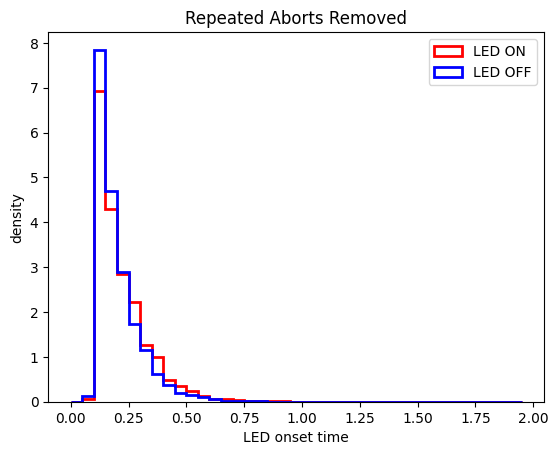

In [13]:
from matplotlib.pyplot import hist


led_onset_ON = aborts_truncated_ON_df['LED_onset_time'].values
led_onset_OFF = aborts_truncated_OFF_df['LED_onset_time'].values

bins = np.arange(0, 2, 0.05)
plt.hist(led_onset_ON, bins=bins, color='r', label='LED ON', density=True, histtype='step', lw=2)
plt.hist(led_onset_OFF, bins=bins, color='b', label='LED OFF', density=True, histtype='step', lw=2)
plt.xlabel('LED onset time')
plt.ylabel('density')
plt.title('Repeated Aborts Removed')
plt.legend();


## stratified sampling

In [14]:
# Create filtered copies of the DataFrame (no alteration of original data)
df = df_repeated_aborts_removed.copy()

df_led_on_truncated_aborts = df[
    (df['LED_trial'] == 1) & 
    (df['timed_fix'] < df['intended_fix']) & 
    (df['timed_fix'] > T_trunc)
].copy()

df_led_off_truncated_aborts = df[
    (df['LED_trial'] == 0) & 
    (df['timed_fix'] < df['intended_fix']) & 
    (df['timed_fix'] > T_trunc)
].copy()

# Define bins for stratification
bin_width = 0.05
bins = pd.interval_range(start=df['LED_onset_time'].min(), 
                         end=df['LED_onset_time'].max() + bin_width, 
                         freq=bin_width)

# Assign strata based on bins
df_led_on_truncated_aborts['strata'] = pd.cut(df_led_on_truncated_aborts['LED_onset_time'], bins=bins, labels=False)
df_led_off_truncated_aborts['strata'] = pd.cut(df_led_off_truncated_aborts['LED_onset_time'], bins=bins, labels=False)

# Find the minimum count for each stratum
min_count_per_stratum = (
    pd.concat([
        df_led_on_truncated_aborts.groupby('strata').size(),
        df_led_off_truncated_aborts.groupby('strata').size()
    ], axis=1).min(axis=1)
)

# Perform stratified sampling
df_led_on_sampled = (
    df_led_on_truncated_aborts.groupby('strata', group_keys=False)
    .apply(lambda group: group.sample(n=min_count_per_stratum.loc[group.name], random_state=42))
)

df_led_off_sampled = (
    df_led_off_truncated_aborts.groupby('strata', group_keys=False)
    .apply(lambda group: group.sample(n=min_count_per_stratum.loc[group.name], random_state=42))
)

# Reset index for the sampled DataFrames (optional)
df_led_on_sampled = df_led_on_sampled.reset_index(drop=True)
df_led_off_sampled = df_led_off_sampled.reset_index(drop=True)




/tmp/ipykernel_322636/2346773985.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_led_on_truncated_aborts.groupby('strata').size(),
/tmp/ipykernel_322636/2346773985.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_led_off_truncated_aborts.groupby('strata').size()
/tmp/ipykernel_322636/2346773985.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_led_on_truncated_aborts.groupby('strata', group_keys=Fals

Text(0.5, 1.0, 'Stratified sampling for LED onset time')

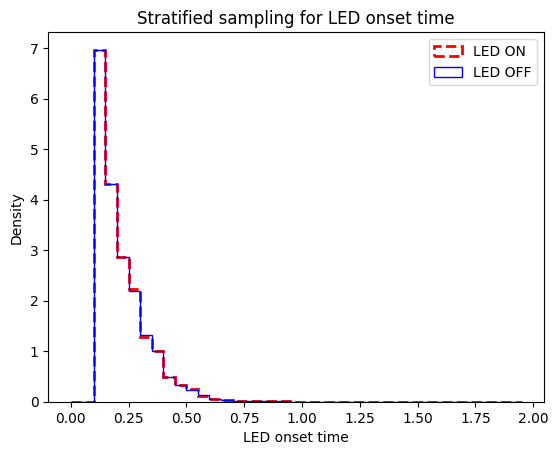

In [15]:
bins = np.arange(0, 2, 0.05)
plt.hist(df_led_on_sampled['LED_onset_time'], bins=bins, density=True, color='r', lw=2, ls='--', label='LED ON', histtype='step')
plt.hist(df_led_off_sampled['LED_onset_time'], bins=bins, density=True, color='b', label='LED OFF', histtype='step')
plt.xlabel('LED onset time')
plt.ylabel('Density')
plt.legend()
plt.title('Stratified sampling for LED onset time')


OG frac_of_led_on_aborts: 0.15126606527115044
OG frac_of_led_off_aborts: 0.12374461979913917


Text(0.5, 1.0, 'LED ON - OFF')

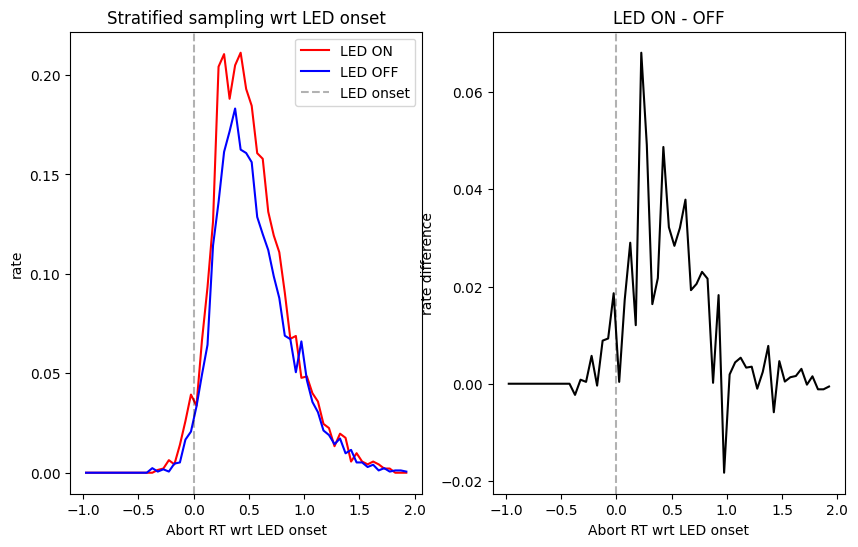

In [16]:
# abort 
aborts_led_on_sampled = df_led_on_sampled['timed_fix'] - df_led_on_sampled['LED_onset_time']
aborts_led_off_sampled = df_led_off_sampled['timed_fix'] - df_led_off_sampled['LED_onset_time']

bins = np.arange(-1, 2, 0.05)
# frac_of_led_on_aborts = len(aborts_led_on_sampled) / len(df[ df['LED_trial'] == 1])
# frac_of_led_off_aborts = len(aborts_led_off_sampled) / len(df[ df['LED_trial'] == 0])

og_frac_ON_aborts = len(df[ (df['LED_trial'] == 1) & (df['abort_event'] == 3) & (df['timed_fix'] > T_trunc) ])/ len(df[ (df['LED_trial'] == 1)  ])
og_frac_OFF_aborts = len(df[ (df['LED_trial'] == 0) & (df['abort_event'] == 3) & (df['timed_fix'] > T_trunc) ])/ len(df[ (df['LED_trial'] == 0)  ])


print(f'OG frac_of_led_on_aborts: {og_frac_ON_aborts}')
print(f'OG frac_of_led_off_aborts: {og_frac_OFF_aborts}')

aborts_led_on_sampled_hist, _ = np.histogram(aborts_led_on_sampled, bins=bins, density=True)
aborts_led_on_sampled_hist *= og_frac_ON_aborts

aborts_led_off_sampled_hist, _ = np.histogram(aborts_led_off_sampled, bins=bins, density=True)
aborts_led_off_sampled_hist *= og_frac_OFF_aborts

t_pts = bins[:-1] + 0.05/2
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(t_pts, aborts_led_on_sampled_hist, label='LED ON', color='r')
plt.plot(t_pts, aborts_led_off_sampled_hist, label='LED OFF', color='b')

plt.xlabel('Abort RT wrt LED onset')
plt.ylabel('rate')
plt.title('Stratified sampling wrt LED onset')
plt.axvline(0, color='k', linestyle='--', alpha=0.3, label='LED onset')
plt.legend();

plt.subplot(1, 2, 2)
plt.plot(t_pts, aborts_led_on_sampled_hist - aborts_led_off_sampled_hist, color='k')
plt.axvline(0, color='k', linestyle='--', alpha=0.3, label='LED onset') 
plt.xlabel('Abort RT wrt LED onset')
plt.ylabel('rate difference')
plt.title('LED ON - OFF')


## error bar

In [21]:
# concated df_led_on_sampled and df_led_off_sampled
import warnings
warnings.filterwarnings("ignore")

df_led_sampled = pd.concat([df_led_on_sampled, df_led_off_sampled], axis=0)
N_shuffle = int(50e3)
bin_width = 0.05
bins = np.arange(-1, 2, bin_width)
on_minus_off_sampled = np.zeros((N_shuffle, len(t_pts)))

def shuffle_and_calc_diff(df_repeated_aborts_removed):
        
        warnings.filterwarnings("ignore")

        df = df_repeated_aborts_removed.copy()

        df_led_on_truncated_aborts = df[
            (df['LED_trial'] == 1) & 
            (df['timed_fix'] < df['intended_fix']) & 
            (df['timed_fix'] > T_trunc)
        ].copy()

        df_led_off_truncated_aborts = df[
            (df['LED_trial'] == 0) & 
            (df['timed_fix'] < df['intended_fix']) & 
            (df['timed_fix'] > T_trunc)
        ].copy()

        # Define bins for stratification
        bin_width = 0.05
        bins = pd.interval_range(start=df['LED_onset_time'].min(), 
                                end=df['LED_onset_time'].max() + bin_width, 
                                freq=bin_width)

        # Assign strata based on bins
        df_led_on_truncated_aborts['strata'] = pd.cut(df_led_on_truncated_aborts['LED_onset_time'], bins=bins, labels=False)
        df_led_off_truncated_aborts['strata'] = pd.cut(df_led_off_truncated_aborts['LED_onset_time'], bins=bins, labels=False)

        # Find the minimum count for each stratum
        min_count_per_stratum = (
            pd.concat([
                df_led_on_truncated_aborts.groupby('strata').size(),
                df_led_off_truncated_aborts.groupby('strata').size()
            ], axis=1).min(axis=1)
        )

        # Perform stratified sampling
        df_led_on_sampled = (
            df_led_on_truncated_aborts.groupby('strata', group_keys=False)
            .apply(lambda group: group.sample(n=min_count_per_stratum.loc[group.name]))
        )

        df_led_off_sampled = (
            df_led_off_truncated_aborts.groupby('strata', group_keys=False)
            .apply(lambda group: group.sample(n=min_count_per_stratum.loc[group.name]))
        )

        df_sampled_shuffled = pd.concat([df_led_on_sampled, df_led_off_sampled], axis=0)
        df_sampled_shuffled['LED_trial'] = np.random.permutation(df_sampled_shuffled['LED_trial'].values)

        # # this is not necessary, because already all of them are aborts. but just for sanity

        df_led_on_truncated_aborts_shuffled = df_sampled_shuffled[
            (df_sampled_shuffled['LED_trial'] == 1) &
            (df_sampled_shuffled['timed_fix'] < df_sampled_shuffled['intended_fix']) &
            (df_sampled_shuffled['timed_fix'] > T_trunc)
        ]
        df_led_off_truncated_aborts_shuffled = df_sampled_shuffled[
            (df_sampled_shuffled['LED_trial'] == 0) &
            (df_sampled_shuffled['timed_fix'] < df_sampled_shuffled['intended_fix']) &
            (df_sampled_shuffled['timed_fix'] > T_trunc)
        ]
            

        abort_rt_wrt_LED_ON_shuffled = df_led_on_truncated_aborts_shuffled['timed_fix'] - df_led_on_truncated_aborts_shuffled['LED_onset_time']
        abort_rt_wrt_LED_OFF_shuffled = df_led_off_truncated_aborts_shuffled['timed_fix'] - df_led_off_truncated_aborts_shuffled['LED_onset_time']

        hist_bins = np.arange(-1, 2, bin_width)

        abort_on_hist_shuffled, _ = np.histogram(abort_rt_wrt_LED_ON_shuffled, bins=hist_bins, density=True)
        abort_off_hist_shuffled, _ = np.histogram(abort_rt_wrt_LED_OFF_shuffled, bins=hist_bins, density=True)


        abort_on_hist_shuffled *= og_frac_ON_aborts
        abort_off_hist_shuffled *= og_frac_OFF_aborts

        return abort_on_hist_shuffled - abort_off_hist_shuffled


In [22]:
from joblib import Parallel, delayed
N_shuffle = int(50e3)
warnings.filterwarnings("ignore")

all_shuffled_diffs = Parallel(n_jobs=-1)(delayed(shuffle_and_calc_diff)(df_repeated_aborts_removed) for _ in range(N_shuffle))

In [23]:
all_shuffled_diffs_np = np.array(all_shuffled_diffs)

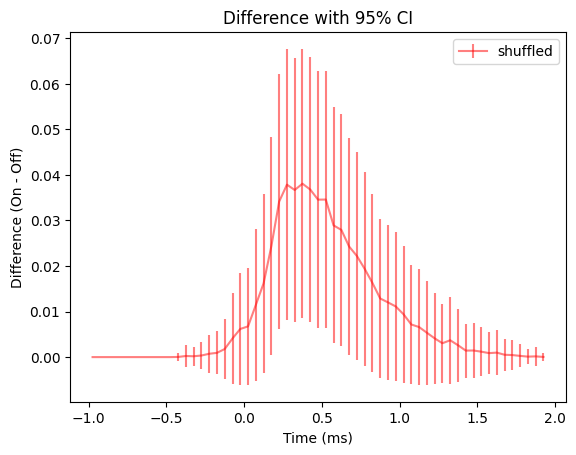

In [24]:
mean = all_shuffled_diffs_np.mean(axis=0)
std = all_shuffled_diffs_np.std(axis=0)
n = all_shuffled_diffs_np.shape[0]
error_95ci = 1.96 * (std)
# Plot with 95% confidence intervals
plt.errorbar(t_pts, mean, yerr=error_95ci, color='r', alpha=0.5, label='shuffled')
plt.xlabel('Time (ms)')
plt.ylabel('Difference (On - Off)')
plt.legend()
plt.title('Difference with 95% CI')
plt.show()

OG frac_of_led_on_aborts: 0.15126606527115044
OG frac_of_led_off_aborts: 0.12374461979913917


Text(0.5, 1.0, 'LED ON - OFF')

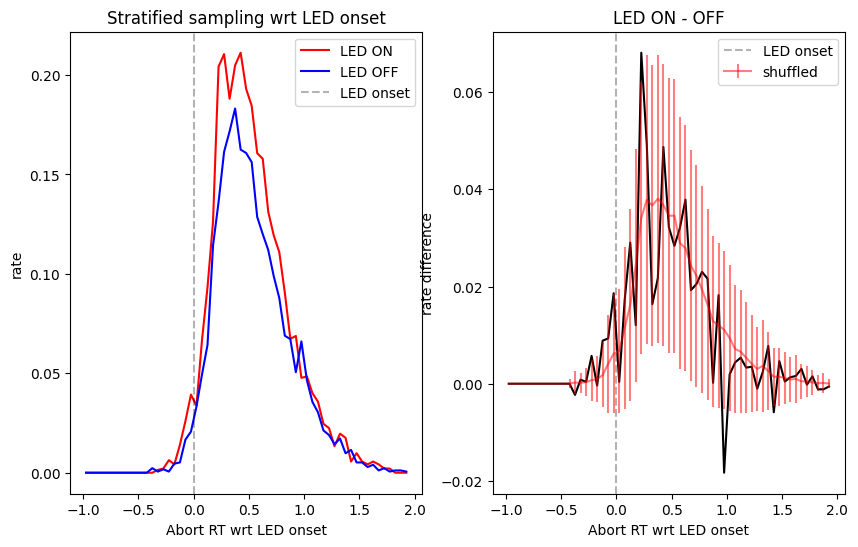

In [25]:
# abort 
aborts_led_on_sampled = df_led_on_sampled['timed_fix'] - df_led_on_sampled['LED_onset_time']
aborts_led_off_sampled = df_led_off_sampled['timed_fix'] - df_led_off_sampled['LED_onset_time']

bins = np.arange(-1, 2, 0.05)
# frac_of_led_on_aborts = len(aborts_led_on_sampled) / len(df[ df['LED_trial'] == 1])
# frac_of_led_off_aborts = len(aborts_led_off_sampled) / len(df[ df['LED_trial'] == 0])

og_frac_ON_aborts = len(df[ (df['LED_trial'] == 1) & (df['abort_event'] == 3) & (df['timed_fix'] > T_trunc) ])/ len(df[ (df['LED_trial'] == 1)  ])
og_frac_OFF_aborts = len(df[ (df['LED_trial'] == 0) & (df['abort_event'] == 3) & (df['timed_fix'] > T_trunc) ])/ len(df[ (df['LED_trial'] == 0)  ])


print(f'OG frac_of_led_on_aborts: {og_frac_ON_aborts}')
print(f'OG frac_of_led_off_aborts: {og_frac_OFF_aborts}')

aborts_led_on_sampled_hist, _ = np.histogram(aborts_led_on_sampled, bins=bins, density=True)
aborts_led_on_sampled_hist *= og_frac_ON_aborts

aborts_led_off_sampled_hist, _ = np.histogram(aborts_led_off_sampled, bins=bins, density=True)
aborts_led_off_sampled_hist *= og_frac_OFF_aborts

t_pts = bins[:-1] + 0.05/2
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(t_pts, aborts_led_on_sampled_hist, label='LED ON', color='r')
plt.plot(t_pts, aborts_led_off_sampled_hist, label='LED OFF', color='b')

plt.xlabel('Abort RT wrt LED onset')
plt.ylabel('rate')
plt.title('Stratified sampling wrt LED onset')
plt.axvline(0, color='k', linestyle='--', alpha=0.3, label='LED onset')
plt.legend();

plt.subplot(1, 2, 2)
plt.plot(t_pts, aborts_led_on_sampled_hist - aborts_led_off_sampled_hist, color='k')
plt.axvline(0, color='k', linestyle='--', alpha=0.3, label='LED onset') 
plt.errorbar(t_pts, mean, yerr=error_95ci, color='r', alpha=0.5, label='shuffled')
plt.legend()
plt.xlabel('Abort RT wrt LED onset')
plt.ylabel('rate difference')
plt.title('LED ON - OFF')


Text(0.5, 1.0, 'Removed Repeated, Stratified Sampling on LED')

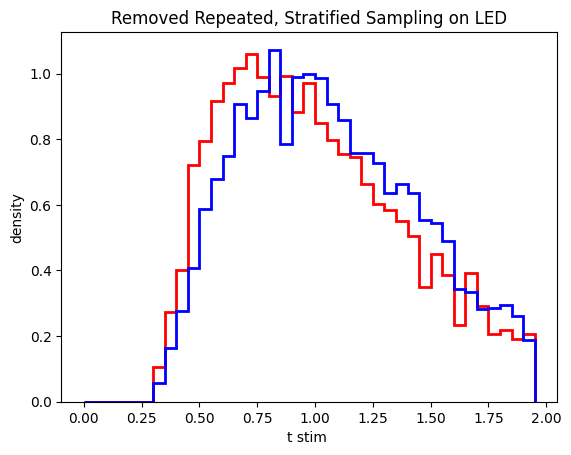

In [29]:
on_t_stim_aborts = df_led_on_sampled['intended_fix']
off_t_stim_aborts = df_led_off_sampled['intended_fix']

bin_width = 0.05
bins = np.arange(0, 2, bin_width)
t_pts = bins[:-1] + bin_width/2

plt.hist(on_t_stim_aborts, bins=bins, density=True, color='r', label='LED ON', histtype='step', lw=2)
plt.hist(off_t_stim_aborts, bins=bins, density=True, color='b', label='LED OFF', histtype='step', lw=2)

plt.xlabel('t stim ')
plt.ylabel('density')
plt.title('Removed Repeated, Stratified Sampling on LED')